# EMPLEANDO DASK PARA LEER LOS DATOS

In [11]:
import dask.dataframe as dd
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing

In [55]:
dsk_df = dd.read_csv('credit_card_transactions-ibm_v2.csv')

In [14]:
# Se extraen sólo las filas donde el fraude es sí 
pd_fraud = dsk_df[(dsk_df['Is Fraud?'] == 'Yes')]
pd_fraud = pd_fraud.compute()

# Se extraen sólo las filas donde el fraude es no y se reduce el tamaño 
# La proporción de reducción es distinta, dado que hay muchos menos casos de fraude que de no fraude
pd_no_fraud = dsk_df[(dsk_df['Is Fraud?'] == 'No')]
pd_no_fraud = pd_no_fraud.sample(frac=0.005, random_state=1)
pd_no_fraud = pd_no_fraud.compute()

# Se genera un dataframe pandas y se guarda el csv
data = pd_fraud.append(pd_no_fraud)
data.to_csv('DownsampleData.csv', index=False)

# PREPROCESADO DE DATOS

In [41]:
data = pd.read_csv('DownsampleData.csv')

In [43]:
# Amount:
# El caracter del dólar es innecesario, se debe eliminar y pasar los datos de tipo object a float.
data['Amount'] = data['Amount'].str.replace(r'$', '')

# Time:
# Se opta por pasar a numérico. Eliminando los minutos se simplifica la variable en 24 clases.
data['Time'] = data['Time'].str[:2]

# Use Chip:
# Como hay 3 únicas clases en el dataset depurado (aunque en Kaggle se aprecia el subconjunto "others") se codifican.
data['Use Chip'] = data['Use Chip'].replace({"Swipe Transaction": 0, "Chip Transaction": 1, "Online Transaction": 2})

# Merchant City:
# También se binariza la columna, sustituyendo ONLINE por 1 y el resto por 0
data['Merchant City'].loc[data['Merchant City'] != 'ONLINE'] = 0
data['Merchant City'].loc[data['Merchant City'] == 'ONLINE'] = 1

# Merchant State:
# Se utiliza un label encoder para codificar los estados
data['Merchant State'].loc[data['Merchant State'].isnull()] = 'No State'   # Se sustituyen los Nan por un string
encoder = LabelEncoder()
encoder.fit(data['Merchant State'])
data['Merchant State'] = encoder.transform(data['Merchant State'])

# Zip:
# Se sustituyen los valores NaN por 0.
data['Zip'].loc[data['Zip'].isnull()] = 0  

# Errors?:
# Para simplificar el dataset se considerarán todos los NaN como 0 (no hay errores) y todos los demás errores como 1.
data['Errors?'].loc[~data['Errors?'].isnull()] = 1  # not nan
data['Errors?'].loc[data['Errors?'].isnull()] = 0   # nan

# Is Fraud?:
# También se binariza la columna, sustituyendo No por 0 y Yes por 1
data['Is Fraud?'].loc[data['Is Fraud?'] == 'No'] = 0
data['Is Fraud?'].loc[data['Is Fraud?'] == 'Yes'] = 1

# Se convierten los datos a floats
data = data .astype(float)

# Se guarda el dataset
data.to_csv('PreprocessedData.csv', index=False)

C:\Users\Alejandro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [56]:
data

,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?
0,0.0,0.0,2015.0,11.0,15.0,12.0,287.13,2.0,-8.194608e+18,1.0,80.0,0.0,3001.0,0.0,1.0
1,0.0,0.0,2015.0,11.0,15.0,13.0,2.41,2.0,-7.759074e+18,1.0,80.0,0.0,5651.0,0.0,1.0
2,0.0,0.0,2015.0,11.0,16.0,9.0,50.81,2.0,-5.513321e+17,1.0,80.0,0.0,4411.0,0.0,1.0
3,0.0,0.0,2015.0,11.0,16.0,9.0,248.36,2.0,4.872341e+18,1.0,80.0,0.0,5732.0,0.0,1.0
4,0.0,0.0,2015.0,11.0,16.0,11.0,473.00,2.0,-8.566952e+18,1.0,80.0,0.0,3640.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151536,1997.0,1.0,2011.0,11.0,26.0,11.0,3.84,0.0,1.799190e+18,0.0,40.0,60616.0,5499.0,0.0,0.0
151537,1955.0,1.0,2014.0,3.0,29.0,8.0,5.19,0.0,4.722913e+18,0.0,70.0,68164.0,5411.0,0.0,0.0
151538,1986.0,0.0,2014.0,2.0,20.0,11.0,10.60,0.0,9.703280e+16,0.0,103.0,37920.0,5411.0,0.0,0.0
151539,1980.0,1.0,2018.0,2.0,21.0,8.0,2.58,0.0,-1.288082e+18,0.0,59.0,49720.0,5499.0,0.0,0.0


# COMPARACIÓN DE PARES DE VARIABLES

In [45]:
data = pd.read_csv('PreprocessedData.csv')

data_in = data.loc[data['Is Fraud?'] == 0.0]
data_out = data.loc[data['Is Fraud?'] == 1.0]

In [46]:
def compare (x,y):
    plt.scatter(data_in[x], data_in[y] )
    plt.scatter(data_out[x], data_out[y], linewidths=5, c='red' )

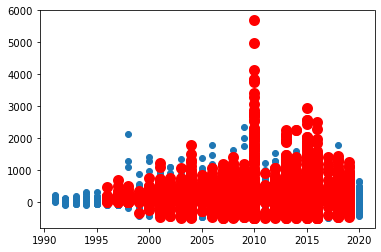

In [47]:
compare('Year','Amount')

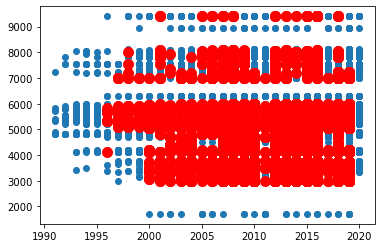

In [48]:
compare('Year','MCC')

# DESARROLLO DEL MODELO DE MACHINE LEARNING

In [49]:
data = pd.read_csv('PreprocessedData.csv')
data['Is Fraud?'].value_counts()

0.0    121784
1.0     29757
Name: Is Fraud?, dtype: int64

In [50]:
# Se cargan las librerías de Machine Learning
import random
from sklearn.model_selection import train_test_split
from sklearn import metrics

from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

from dtreeviz.trees import *
from IPython.core.display import display, HTML

In [51]:
# Se aislan las variables de entrada 'X' de la variable predictora 'y', la que queremos hallar
X = data.drop('Is Fraud?', axis=1)     # Variables 'X', todas menos la etiqueta 'Is Fraud', la variable predictora
y = data['Is Fraud?']                  # Variable 'y', la etiqueta binaria 'Is Fraud'

# Se convierten las variables a numpy para posteriormente poder aplicar reshape y adaptar su dimensión
X = np.nan_to_num(X)
y = np.nan_to_num(y)

# Finalmente, para evitar overfitting se dividen el conjunto de datos en conjunto de entrenamiento y de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_test = X_test.reshape(-X_test.shape[0],X_test.shape[1])    #Reshape de X_test para poder introducirlo

In [52]:
def metricas ():
    print("-----------------------------------------------------")
    print('Métricas de error:')
    print('MAE', metrics.mean_absolute_error(y, y_pred))  
    print('MSE', metrics.mean_squared_error(y, y_pred))  
    print('RMSE:', np.sqrt(metrics.mean_squared_error(y, y_pred)))
    print("-----------------------------------------------------")
    print('Matriz de Confusión:')
    print(metrics.confusion_matrix(y, y_pred))
    print("-----------------------------------------------------")
    print('Report:')
    print(metrics.classification_report(y, y_pred))

In [53]:
print("RANDOM FOREST")
clf = RandomForestClassifier(n_estimators = 10, criterion = 'gini', random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X)

metricas()

RANDOM FOREST
-----------------------------------------------------
Métricas de error:
MAE 0.00979272936037112
MSE 0.00979272936037112
RMSE: 0.09895822027689827
-----------------------------------------------------
Matriz de Confusión:
[[121572    212]
 [  1272  28485]]
-----------------------------------------------------
Report:
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99    121784
         1.0       0.99      0.96      0.97     29757

    accuracy                           0.99    151541
   macro avg       0.99      0.98      0.98    151541
weighted avg       0.99      0.99      0.99    151541



In [54]:
print("K NEAREST NEIGHBORS")
clf = KNeighborsClassifier(n_neighbors=3)
clf.fit(X_train, y_train)
y_pred = clf.predict(X)

metricas()

K NEAREST NEIGHBORS
-----------------------------------------------------
Métricas de error:
MAE 0.036683141855999364
MSE 0.036683141855999364
RMSE: 0.19152843615505077
-----------------------------------------------------
Matriz de Confusión:
[[120133   1651]
 [  3908  25849]]
-----------------------------------------------------
Report:
              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98    121784
         1.0       0.94      0.87      0.90     29757

    accuracy                           0.96    151541
   macro avg       0.95      0.93      0.94    151541
weighted avg       0.96      0.96      0.96    151541



In [40]:
# DESARROLLO DEL MODELO DE DEEP LEARNING